# Netflix Stock Price Forecasting Model

# Summary

The dataset for this project originates from [kaggle](https://www.kaggle.com/datasets/akpmpr/updated-netflix-stock-price-all-time) and contains Netflix daily stock prices between 2002 and 2021.

In this project, we will employ Recurrent Neural Network (RNN) and Long Short-Term Memory (LSTM) to predict stock market indices. We are interested in forecasting the 'Close' series.

# Load and Exploratore the Data

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
from datetime import datetime
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('./netflix.csv',sep=",")
data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2002-05-23,1.242857,1.145714,1.156429,1.196429,104790000.0,1.196429
1,2002-05-24,1.225000,1.197143,1.214286,1.210000,11104800.0,1.210000
2,2002-05-28,1.232143,1.157143,1.213571,1.157143,6609400.0,1.157143
3,2002-05-29,1.164286,1.085714,1.164286,1.103571,6757800.0,1.103571
4,2002-05-30,1.107857,1.071429,1.107857,1.071429,10154200.0,1.071429


In [3]:
data['Close'].isnull().sum()

0

In [4]:
data = data[['Date', 'Close']]
data.sample(5)

,Date,Close
2710,2013-02-28,26.868570
3536,2016-06-09,97.089996
1581,2008-09-03,4.415714
1341,2007-09-20,2.782857
4383,2019-10-21,278.049988


# Feature Transformation

- Replace comma in **Close** column and convert values into float64
- Transform **Date** column into a datetime object 

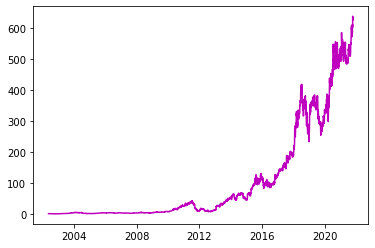

In [5]:
def make_date(row):
    return datetime(year = int(row.split('-')[0]), 
                    month = int(row.split('-')[1]), 
                    day = int(row.split('-')[2]))

data['Date'] = data['Date'].apply(make_date)
data.set_index(data.Date,inplace=True)
data.drop(columns=['Date'], inplace=True)

plt.plot(data, 'm')

# Split the Data and Apply Feature Scaling

- Split the data into train and test data sets using **timestep = 50 days**
- use **MinMaxScaler** to scale the data

In [6]:
timesteps = 50

In [7]:
train = data[:len(data)-timesteps]['Close'].values
test = data[len(train):]['Close'].values
train=train.reshape(train.shape[0],1)
test=test.reshape(test.shape[0],1)

In [8]:
sc = MinMaxScaler(feature_range= (0,1))
train = sc.fit_transform(train)

In [9]:
train_X = []
train_y = []

for i in range(timesteps, train.shape[0]):
    train_X.append(train[i-timesteps:i,0])
    train_y.append(train[i,0])

train_X = np.array(train_X)
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
train_y = np.array(train_y)

In [10]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))

Training input shape: (4781, 50, 1)
Training output shape: (4781,)


In [11]:
inputs = data[len(data) - len(test) - timesteps:]
inputs = sc.transform(inputs)

test_X = []

for i in range(timesteps, 100):
    test_X.append(inputs[i-timesteps:i,0])

test_X = np.array(test_X)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

In [12]:
test_X.shape

(50, 50, 1)

# Train models

- Simple **RNN** layers each with 50 hidden units and tanh activation function per cell
- **LSTM** with 70 hidden units per cell
- Define the loss function and optimizer strategy
- Fit the model with 100 epochs
- Predict and plot the results 

## RNN

In [13]:
model_RNN = Sequential() 

model_RNN.add(SimpleRNN(50, activation='tanh',
                    input_shape=(train_X.shape[1],1), return_sequences = True))
model_RNN.add(Dropout(0.2))
model_RNN.add(SimpleRNN(50, activation='tanh', return_sequences = True,))
model_RNN.add(Dropout(0.2))
model_RNN.add(SimpleRNN(50, activation='tanh', return_sequences = True,))
model_RNN.add(Dropout(0.2))
model_RNN.add(SimpleRNN(50, activation='tanh'))
# output layer to make final predictions 
model_RNN.add(Dense(1))

model_RNN.compile(loss='mean_squared_error', optimizer='adam')
model_RNN.fit(train_X, train_y, epochs=100, batch_size=32, verbose=0)

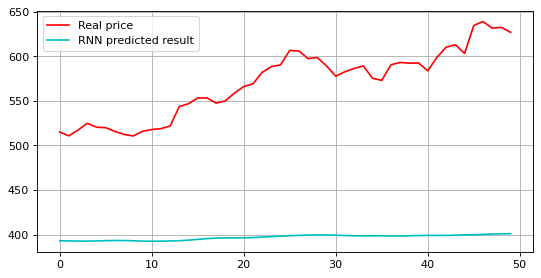

In [14]:
predicted_RNN = model_RNN.predict(test_X)
predicted_RNN = sc.inverse_transform(predicted_RNN)

plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="red",label="Real price")
plt.plot(predicted_RNN,color="c",label="RNN predicted result")
plt.legend()
plt.grid(True)
plt.show()

## LSTM

In [15]:
model_LSTM = Sequential() 
model_LSTM.add(LSTM(70, input_shape=(train_X.shape[1],1)))
model_LSTM.add(Dense(1))

model_LSTM.compile(loss='mean_squared_error', optimizer='adam')
model_LSTM.fit(train_X, train_y, epochs=100, batch_size=32, verbose=0)

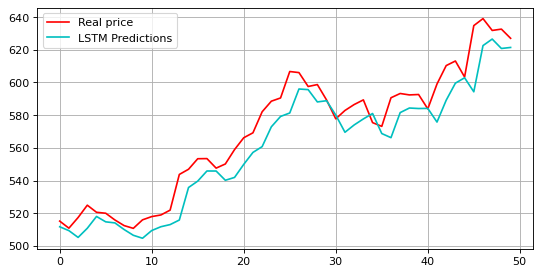

In [16]:
predicted_LSTM = model_LSTM.predict(test_X)
predicted_LSTM = sc.inverse_transform(predicted_LSTM)

plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="red",label="Real price")
plt.plot(predicted_LSTM,color="c",label="LSTM Predictions")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# RNN structure
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5

In [18]:
# LSTM structure
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 70)                20160     
                                                                 
 dense_1 (Dense)             (None, 1)                 71        
                                                                 
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________


# Results

If we compare the model summary for **Simple RNN** with the model summary for **LSTM**, we can see that there are more trainable parameters for the **LSTM**, which explains why it took a longer time to train this model.

Overall the plots show that our **LSTM** model with a less complex structure still performed better than our Simple RNN.  The latter one predict very weak.

# Next Steps

To improve the quality of forecasts over many time steps, we'd need to use more data and more sophisticated LSTM model structures. We could try training with more data or increasing cell_units and running more training epochs.